# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Joyal Joy Madeckal
#### Student ID: S3860476

Date: XXXX

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* numpy
* pandas
* seaborn
* gensim
* matplotlib
* sklearn
* nltk

## Introduction

The aim of the assessment task here is to generate 7 different feature representations for about 55000 job advertisement description spread across 8 different categories. The following feature representations were done as part of the assessment
1. Count vector
2. FastText Language Model - Unweighted and TF-IDF Weighted
3. Word2Vec Language Model - Unweighted and TF-IDF Weighted
4. Glove Language Model - Unweighted and TF-IDF Weighted


Followed by the feature representations, we will do the modelling based on all the feature representations and will compare the different models created. As it is not a good idea to depend only on a single iteration for model accuracies we will be doing 5 fold cross validations of the model to ensure robustness of the models. We are asked one more research question in the assessment task - If we are considering extra information how can it affect the model accuracy. This part of the assessment will be done by combining Title and Description of the job advertisements.

## Importing libraries 

In [1]:
# Loading the required libraries for performing the task
import time
start_doc = time.time()

import numpy as np
import pandas as pd
import seaborn as sns
import gensim.downloader as api
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from gensim.models.fasttext import FastText
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

### Count Vector Representation

We have to generate feature representation of the advertisement descriptions. For doing this, we have to load the vocabulary and the advertisement description on the first place. Loading the required data in the code block below.

In [2]:
# Loading the vocabulary.
with open('vocab.txt') as vocab:
    vocabulary_with_indices = vocab.read().splitlines()

# Removing the indices and creating the vocabulary
vocabulary = [word.split(':')[0] for word in vocabulary_with_indices]

# loading the advertisement descriptions.
with open('job_ads.txt') as job_ads:
#     We are reading the whole data. The data includes additional information other than description
    all_data = job_ads.read().splitlines()

# Extracting the descriptions from the data loaded.
job_ads_descriptions = [data.lstrip('Description:').strip() for data in all_data if data.startswith('Description:')]
# Extracting the Webindex as it is required for creating the count vector text file
job_ads_webindices = [data.lstrip('Webindex:').strip() for data in all_data if data.startswith('Webindex:')]
# Extracting the Category as it is required for classification task
job_ads_categories = [data.lstrip('Category:').strip() for data in all_data if data.startswith('Category:')]
# Extracting the Tite as it is required for classification task
job_ads_titles = [data.lstrip('Title:').strip() for data in all_data if data.startswith('Title:')]

As we have loaded the data and extracted in the suitable format for further processing, we can proceed with creation of feature vectorization. First we will initialise the count vectorizer and do the feature vectorization. 

In [3]:
# Initialization of the count vectorizer
count_vectorizer = CountVectorizer(analyzer = "word",vocabulary = vocabulary)

# Generating the count vector representation of all descriptions. 
count_features = count_vectorizer.fit_transform(job_ads_descriptions)
count_features.shape

(55449, 40038)

We have performed the count vectorization of all the descriptions. Now, we have to see if it is done properly by comparing the actual description and count vectorized data of the description by printing side by side. 

In [4]:
# Setting an random data and printing the count vectorized form and actual description 
random_index = 10
print('Actual Description :', '\n', job_ads_descriptions[random_index])
print('\nCount Vectorized form :')
for word, value in zip(vocabulary, count_features[random_index].toarray()[0]):
    if value > 0:
        print(word+":"+str(value), end =' ')

Actual Description : 
 behalf stable global leicester hunt project background point career developer ideally coming asp net background project managers due sheer growth project responsible defining scope projects resource requirements project governance accountable end end delivery risk managing relationships partners suppliers develop communication strategy engage stakeholders maintain wider track record project ideally qualified prince line beneficial delivering range systems intelligence data warehousing distribution transportation systems ideally areas past tangible developing realworld data driven applications opposed fancy websites gained industry complete software lifecycle preferably multiple methodology models agile practices methodologies test driven scrum savvy credibility front senior managers equally stuff technically asp net ensure continually challenged giving full projects involved ready interview immediately keen real passion drive offer applicant interested spec give 

The above data ensures us that the count vectorization is done correct. Now, we will be proceeding to save the data in the required format.

### Saving outputs

Saving the count vector representation of the descriptions.

In [5]:
start = time.time()
# Opening the file for writing the data.
with open('count_vectors.txt', 'w') as c_vec:
    for index, feature in enumerate(count_features): # Looping through each count vectorized description
        print(f'#{job_ads_webindices[index]},', end = '', file = c_vec) # Printing the first line for the description including "#" and Webindex
        nonzero_indices = feature.nonzero()[1] # Getting all the nonzero indices, meaning indices of the words available in the description
        for i in range(len(nonzero_indices)): # Looping through the word indices
            print(f'{nonzero_indices[i]}:{feature.toarray()[0, nonzero_indices[i]]}', end = ',' if i < len(nonzero_indices)-1 else '\n', file = c_vec) # Printing the vector representation word by word.
time.time() - start

88.8300108909607

We have saved the count vector as a file above. 

Now, we have to start the creation of the word embedding models for the documents.

### FastText Model - Unweighted Vector Representation

FastText model can generate word embedding even if the word is not available in the provided vocabulary. Here, we are going to train the FastText model on the descriptions of the job advertisements itself. First, we will generate the document vector representation of all the documents without considering weightage. The following steps will be followed for generating the FastText model. 

- We will initialise the FastText model as `job_ads_FT`
- We will generate the tokens of the corpus from the description available
- Build the vocabulary from the corpus.
- Train the FastText model based on the corpus.

In [4]:
start = time.time()

# Initialising the FastText model with vector size of 200
job_ads_FT = FastText(vector_size=200)

# Tokenising the descriptions
job_ads_tokens = [[token for token in desc.split(' ')] for desc in job_ads_descriptions]

# Building the vocabulary
job_ads_FT.build_vocab(corpus_iterable = job_ads_tokens)

# Training the FastText model
job_ads_FT.train(
    corpus_iterable = job_ads_tokens, epochs=job_ads_FT.epochs,
    total_examples=job_ads_FT.corpus_count, total_words=job_ads_FT.corpus_total_words,
)

print(job_ads_FT)
time.time() - start

FastText(vocab=22816, vector_size=200, alpha=0.025)


200.11445784568787

We have created the FastText model now. The next task is to generate the document embeddings from the model we have created. Overall in this assessment we have to create these document embeddings 6 times. So, we will create a generic method for creating the document embeddings. Document embeddings are created from the word embeddings by summing up all the word embeddings. 

We have to create document embeddings for 55,449 descriptions and it is pretty huge. We are expecting the output of the function as a dataframe of document embeddings. As we have huge data to process, if we go by appending the data to a dataframe it will take huge amount of time. So, our approach will be to have a dictionary list of the word embedding and document embedding which will be converted to a dataframe at the end of the function.

The function takes 3 arguments:
   - wv -> word:embedding dictionary
   - tk_txts -> list of tokenised texts, each representing a description
   - vector_size -> expected size of the embedding, will take a default values as zero

The function works as below:
   - Initialise the dictionary list `docs_vectors`
   - Loop through each tokenised descriptions
   - Store the tokenised description in `tokens`
   - Initialising the `temp` variable which will hold the word embeddings for the document. Size of key = vector size, Length of values = Number of tokens. Eg:  {0:[-2.33, 1.70459], 1: [-4.07999, -6.1254, 6666]}
   - Loop through each token
   - Get the embedding for each token
   - Update the `temp` variable with each embedding
   - Once the complete word embedding for a description is generated `docs_vectors` list will be updated by summing up the corresponding values of `temp`.
   - `docs_vectors` is converted to a dataframe and then returned as the result of the function

In [5]:
# This method is used for generating the vector representations of the documents.
def gen_docVecs(wv,tk_txts, vector_size = 0):
    docs_vectors = [] # initialise document embeddings dictionary list
    for i in range(0,len(tk_txts)): # Loopint thorugh tokenised descriptions
        tokens = tk_txts[i]
        temp = {x:[] for x in range(wv.vector_size if not vector_size else vector_size)} # Temporary object holding the word embeddings
        for w_ind in range(0, len(tokens)):
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # Getting the word vector for the token
                for j in range(0,len(word_vec)):
                    temp[j].append(word_vec[j]) # Updating the temporary object
            except: # if the word is unable to be found in the embeddings instead of throwing error we are catching it in the except
                pass 
        docs_vectors.append({key:sum(temp[key]) for key in temp.keys()}) # Updating the document embedding dictionary list by summing up values of the temporary object
    return pd.DataFrame(docs_vectors) # Returing the data frame of document embeddings

In [6]:
start = time.time()
# Generating the document embeddings based on unweighed FastText model.
job_ads_dvs_FT = gen_docVecs(job_ads_FT.wv, job_ads_tokens)
# Checking if there are any missing values.
print(job_ads_dvs_FT.isna().any().sum())
time.time() - start

0


475.77028632164

In [9]:
# Printing the shape of the document embedding created to ensure the correctness.
job_ads_dvs_FT.shape

(55449, 200)

In [10]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_FT.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
42072,15.613812,-45.952852,-52.220957,3.820475,50.322373,26.174448,71.872819,4.931284,-76.263389,16.663540,...,25.140469,31.873225,-98.615976,32.989694,-20.666999,33.379914,33.806812,4.367390,-37.342034,6.283796
7020,32.188376,-41.098734,-33.086647,26.835976,-46.213098,33.001576,10.117716,49.479345,-33.634035,3.115351,...,48.709089,36.321310,-82.574426,36.252472,-1.750777,-22.817295,103.227857,39.397147,-111.657429,-53.925161
26149,27.446207,-61.895403,-21.662518,4.923539,-4.857310,-21.398938,7.142293,8.940022,12.701246,45.365400,...,51.096608,-55.188279,19.674915,3.685685,3.728998,7.206112,-33.706409,-45.901876,-7.052063,-75.533504
40930,44.421413,-10.155136,-43.347911,-11.948087,-5.023926,2.988588,27.563354,2.348795,52.150198,15.733839,...,10.912509,-14.535719,-21.860798,-1.635208,3.978314,21.579183,6.011819,-48.581131,9.873253,-25.577746
9322,1.294301,-34.605345,-1.255512,19.697138,-38.432141,17.001988,24.417292,23.267569,-23.301519,17.626669,...,3.994269,-17.292763,-42.753310,11.440806,-26.590013,7.387669,27.372485,14.929920,-18.788950,13.708678


### FastText Model - TF-IDF Weighted Vector Representation

Now, instead of simply summing up the word embeddings we are going to consider the tf-idf weightage for each of the words. That is, instead of storing the word embedding we will multiply the word embedding with the tf-idf weightage of the word. For doing this, first we have to create the tf-idf vector representation of the documents and will be done below.

In [7]:
# Initialising the tf-idf vectorizer 
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocabulary)

# Generating the tf-idf vector representation of all the descriptions
tfidf_features = tfidf_vectorizer.fit_transform(job_ads_descriptions)

# Printing the shape of the tf-idf vector to ensure the correctness.
tfidf_features.shape

(55449, 40038)

We have created the tf-idf feature representation of all the descriptions. We cannot directly proceed with the generated feature. To proceed, we will create a dictionary list of descriptions where each dictionary represents a description and the content will be the words in the description followed by the corresponding tf-idf weight of the word in the document.

A generic function is written for generating the tf-idf weights `create_wordweights`

The function takes the following arguments:
   - features -> The tf-idf feature representation of the descriptions.
   - vocab -> Vocabulary of the descriptions which we have generated
   
The function works as below:
   - Initialise the `tfidf_weights` to an empty list
   - Loop through each feature
   - Extract the nonzero indices, i.e indices of words available in the description
   - Create the weighted object `weighted_obj`
   - Append `weighted_obj` to `tfidf_weights`
   - Return the complete `tfidf_weights`. The structure will be like: [{'word1': 0.04123, 'word2' : 0.635}, {'word2': 0.5555}]

In [8]:
def create_wordweights(features, vocab):
    tfidf_weights = [] # Initialising the tf-idf weights dictionary list
    
    for feature in features: # Looping through the features
        nonzero_indices = feature.nonzero()[1] # Extracting the indices of words appearing in the feature
        weighted_obj = {vocab[index]:feature.toarray()[0, index] for index in nonzero_indices} # Creation of the weighted object based on the indices extracted
        tfidf_weights.append(weighted_obj) # Updating tf-idf weights with the latest weighted object created
    return tfidf_weights 

# Invoking the function and creating the weighted dictionary list.
tfidf_weights = create_wordweights(tfidf_features, vocabulary)
# Printing the data of the first description to ensure correctness.
tfidf_weights[0]

{'years': 0.041590542795583656,
 'workload': 0.07732175012039134,
 'water': 0.5286729566108767,
 'uv': 0.14982015121823747,
 'treatment': 0.16407476000533092,
 'tailoring': 0.12993687026598563,
 'systems': 0.0874279713366735,
 'supplier': 0.07259254600891585,
 'solutions': 0.046187881358403474,
 'softeners': 0.3220111352242161,
 'servicing': 0.08680694862092261,
 'seeking': 0.050286797021186276,
 'sampling': 0.12071529492890433,
 'routine': 0.0932573883599681,
 'reverse': 0.26741349387597624,
 'return': 0.058710613482731745,
 'results': 0.06350568212526252,
 'responsibilities': 0.044233371866369775,
 'requirements': 0.04039193437758663,
 'relevant': 0.04718681220880245,
 'recruit': 0.05243298838673115,
 'ranging': 0.08653069973907888,
 'quality': 0.0416852305217405,
 'product': 0.051321663794658495,
 'practice': 0.05799010332874837,
 'plants': 0.11640863076245764,
 'planet': 0.13457923751449027,
 'package': 0.048082241161251815,
 'osmosis': 0.3328705376055253,
 'offering': 0.0570487077

We have created the tf-idf weights for the descriptions. Next task is form the document vector embeddings considering the tf-idf weights. For this, we can use the `gen_docVecs` function with a minor modification. Instead of storing the word embedding directly we will multiply each of the word embeddings with the corresponding tf-idf weights.

The function `gen_docVecs_with_tfidf_weights` has one extra argument than `gen_docVecs`:
   - tfidf -> The tf-idf weighted dictionary list, by default set to an empty list
   
The function works same as the function `gen_docVecs` with one addition:
   - After the word embedding is formed, we will mutiply the word embedding with the tf-idf weights from `tfidf`
   - Returns document embeddings as a data frame considering the tf-idf weights.
   
As the function is already described before, will give the necessary comments here.

In [9]:
def gen_docVecs_with_tfidf_weights(wv, tk_txts, tfidf = [], vector_size = 0):
    docs_vectors = []
    
    for i in range(0,len(tk_txts)):
#         Here, we are considering the unique words in the dictionary since when we generated the tf-idf weights the word frequencies are already considered.
        tokens = list(set(tk_txts[i]))
        temp = {x:[] for x in range(wv.vector_size if not vector_size else vector_size)}
        for w_ind in range(0, len(tokens)):
            try:
                word = tokens[w_ind]
                word_vec = wv[word]
                weighted_word_vec = word_vec * tfidf[i][word] # Creation of the weighted word embedding
                for j in range(0,len(weighted_word_vec)):
                    temp[j].append(weighted_word_vec[j]) # Instead of the simple word embedding appending the weighted word embedding to temp object
            except:
                pass
        docs_vectors.append({key:sum(temp[key]) for key in temp.keys()})
    return pd.DataFrame(docs_vectors)

In [10]:
start = time.time()
# Generating the tf-idf weighted FastText document embeddings
job_ads_dvs_FT_weighted = gen_docVecs_with_tfidf_weights(job_ads_FT.wv, job_ads_tokens, tfidf_weights)
# Ensuring there are no missing values.
print(job_ads_dvs_FT_weighted.isna().any().sum())
time.time() - start

0


377.1000335216522

In [15]:
# Printing the shape of the document embedding created to ensure the correctness.
job_ads_dvs_FT_weighted.shape

(55449, 200)

In [16]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_FT_weighted.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
51266,1.403227,-3.111271,0.967533,0.757639,0.436254,0.869809,2.198704,-0.401136,1.433578,2.619193,...,1.973995,-4.281115,-2.872512,-0.118933,1.053995,1.107426,-2.732682,-1.197356,-1.196988,-3.014297
44774,0.810339,-1.084329,1.628165,2.365907,-2.006624,2.041735,4.497620,1.129983,-1.203740,-1.749824,...,1.711042,-3.795215,-2.523760,4.104766,-0.725173,1.505395,1.126513,0.181569,-3.769793,-0.984167
13692,-2.189523,-1.428678,-0.423347,-0.664131,0.125783,1.888103,-1.117737,-1.632925,0.469370,-0.221725,...,-1.083399,1.544594,-2.130048,1.312305,-1.185996,-1.573005,-0.179797,-0.049833,-3.113453,0.537827
27218,9.518688,-3.373415,-4.650344,-1.233585,-0.284106,-1.565707,2.976132,0.873204,4.631994,2.261179,...,0.515053,-3.598429,-4.401669,1.905203,0.067755,2.254684,-2.795507,-7.943103,-0.082109,-6.294566
45755,2.594151,-1.165721,0.269828,1.506906,-4.710356,1.531107,-1.984268,-0.411355,0.974042,-0.298304,...,3.426434,-1.692413,-1.798104,3.113868,0.975005,-0.750757,2.890854,-2.102058,-3.087957,-5.398960


### Pre trained Word2Vec Model - Unweighted Vector Representation

We are using the pre trained word2vec model now for generating the document embeddings. Here, we are going to use `word2vec-google-news-300` for the pre trained word2vec model. We will load the complete model using `api.load` from `gensim.downloader` and proceed with the document embeddings creation.

In [11]:
# Loading the pre trained word2vec model
preTrained_w2v_wv = api.load('word2vec-google-news-300')
preTrained_w2v_wv.vector_size

300

In [18]:
# Inspecting the number of words present in the model
len(preTrained_w2v_wv.index_to_key)

3000000

As the model is loaded now we can use `gen_docVecs` function for generating the document embeddings based on the word2vec model and will be carried out below.

In [12]:
start = time.time()
# Generating the document embeddings.
job_ads_dvs_w2v = gen_docVecs(preTrained_w2v_wv, job_ads_tokens)
# Ensuring there are no missing values.
print(job_ads_dvs_w2v.isna().any().sum())
time.time() - start

0


691.0555999279022

In [20]:
# Inspecting the shape of the document embeddings generated.
job_ads_dvs_w2v.shape

(55449, 300)

In [21]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_w2v.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
48666,-6.594147,5.514931,6.878727,6.612236,-6.845245,2.947937,5.642521,-11.626717,10.367905,1.436413,...,-24.347282,9.248245,-9.975658,8.430725,-3.144772,-2.805389,5.085171,-1.870850,0.335834,-3.218018
1289,1.239075,1.344101,-3.916275,1.942566,-4.638855,2.234314,3.776367,-1.535675,5.262554,1.640309,...,-2.691010,3.851181,-2.386230,-1.462708,1.534180,-2.108505,3.321949,-2.264496,-1.145691,1.366150
42418,-2.663986,0.375336,1.709793,4.769829,-1.001923,1.587158,0.844757,-6.120682,4.212097,3.486145,...,-1.905701,1.480428,-8.900146,4.121150,-0.414276,-2.581551,4.443939,-4.646301,2.493355,-0.052124
3171,-3.433838,2.018440,1.426538,6.608547,-0.314560,-3.272220,8.579231,-5.814497,3.542483,0.067490,...,-8.035988,2.532211,-6.565292,1.604099,0.756683,4.172661,1.992056,-5.595544,5.288940,-3.790753
37082,-9.459915,4.580860,-3.621319,10.345760,-3.632477,0.624998,5.888748,-9.993787,12.578918,-1.915203,...,-10.681751,7.069809,-8.511899,3.519447,-5.629253,4.629972,3.074241,-5.517867,1.340504,-5.463623


### Pre trained Word2Vec Model - TF-IDF Weighted Vector Representation

Now, we are going to consider the tf-idf weightage for generating the document embeddings with the word2vec model. It is perfromed in the code block below. We will be using `gen_docVecs_with_tfidf_weights` function for this as it is a generic method.

In [24]:
start = time.time()
# Generating the tf-idf weighted document embeddings.
job_ads_dvs_w2v_weighted = gen_docVecs_with_tfidf_weights(preTrained_w2v_wv, job_ads_tokens, tfidf_weights)
# Ensuring there are no missing values.
print(job_ads_dvs_w2v_weighted.isna().any().sum())
time.time() - start

0


512.3327169418335

In [23]:
# Inspecting the shape of the document embeddings generated.
job_ads_dvs_w2v_weighted.shape

(55449, 300)

In [24]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_w2v_weighted.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
21171,-0.848256,0.218645,0.144386,0.823035,-0.365938,0.460666,0.652607,-1.020107,-0.225447,-0.430827,...,-0.532707,0.141023,-0.694752,0.503378,0.048788,0.300979,-0.103318,-0.048250,0.806804,0.011269
3284,0.008079,0.009140,0.039198,0.118324,-0.205410,0.153803,-0.001273,-0.132292,0.169827,0.018599,...,-0.053208,-0.020617,-0.052143,-0.019864,0.121675,-0.125318,0.037670,-0.016276,0.028775,-0.106704
41818,-0.551115,0.400913,-0.170610,0.521144,-0.336232,0.095659,0.345029,-0.628490,0.419388,0.173227,...,-0.613062,0.645835,-1.135992,0.285688,-0.195189,-0.100661,0.550934,-0.152633,0.206149,-0.240557
1736,-0.016389,-0.098971,-0.298781,0.317951,-0.308320,0.353680,-0.014131,-0.173771,0.607032,0.765647,...,-0.364962,0.387496,-0.267760,0.264457,0.188009,0.113377,0.012082,-0.350808,-0.115901,0.126536
29218,-0.124017,0.015610,0.012444,0.572343,-0.525178,0.214822,-0.193738,-0.215148,0.600033,0.269803,...,0.087448,0.112269,-0.221269,0.009500,-0.134180,-0.510498,-0.282881,-0.260849,-0.213561,0.076215


### Pre trained Glove Model - Unweighted Vector Representation

We will now use the Glove model for generating the document embeddings. We will use the 200 vector size model for this. The model has to be created by reading the data file `glove/glove.6B.200d.txt`. Once the data is read we have to extract the information with the following structure:  {word: embeddings}. It is done in the below code block.

In [13]:
# Opening the data file for reading
with open('glove/glove.6B.200d.txt', encoding='utf-8') as glove_data:
#    Reading the data and each word will be stored as a list item
    all_data = glove_data.read().splitlines()
#    Creation of the model. Here, we will split the data into word and embeddings. We used numpy array for the embeddings so that it can be easily converted to float data type. 
    preTrained_glove_wv = {data.split(' ')[0]:np.array(data.split(' ')[1:]).astype('float64') for data in all_data}

In [26]:
# Inspecting the size of the model.
len(preTrained_glove_wv.keys())

400000

In [27]:
# Inspecting the vector size of the model.
len(list(preTrained_glove_wv.values())[0])

200

As the model is loaded now we can use `gen_docVecs` function for generating the document embeddings based on the glove model and will be carried out below.

In [14]:
start = time.time()
# Generating the document embeddings
job_ads_dvs_glove = gen_docVecs(preTrained_glove_wv, job_ads_tokens, 200)
# Ensuring there are no missing values.
print(job_ads_dvs_glove.isna().any().sum())
time.time() - start

0


433.3229992389679

In [29]:
# Inspecting the shape of the document embeddings generated.
job_ads_dvs_glove.shape

(55449, 200)

In [30]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_glove.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
20252,3.904971,1.574108,-1.472508,-1.215675,7.778478,-3.105694,-5.568024,3.692002,4.110144,-1.137400,...,-2.182195,1.527969,1.230072,1.431869,5.002397,-1.482247,-2.209013,2.801946,-1.541570,4.994627
50198,15.835299,-1.852163,-0.775665,-20.886971,-1.194009,-1.902595,-22.972196,-3.221480,-1.475372,-7.173431,...,-0.755581,-4.065006,-32.650811,17.052240,4.997956,19.310657,18.522056,-10.263908,-7.239119,14.358802
7083,5.529558,8.813215,7.025633,4.103991,25.176362,-6.422680,-29.002098,-7.955885,-13.555286,-12.934122,...,-2.213754,13.692523,4.134709,20.990754,-4.823732,-3.019156,14.416869,7.178772,-4.596699,1.887743
49688,17.691306,28.209642,14.361150,-15.087278,15.365421,2.901023,-38.998626,10.247396,2.051629,27.541055,...,-7.462519,-2.315890,-8.582082,20.982211,11.831511,-10.204578,17.253739,1.080011,-7.594183,1.144355
37015,9.333878,18.503656,4.667220,-15.324405,14.886980,-1.159405,-23.198899,2.328847,7.339338,-2.007281,...,-9.931242,0.195206,-1.031681,21.644094,14.738612,0.841391,1.209323,-0.711345,5.968168,8.877956


### Pre trained Glove Model - TF-IDF Weighted Vector Representation

Now, we are going to consider the tf-idf weightage for generating the document embeddings with the glove model. It is perfromed in the code block below. We will be using `gen_docVecs_with_tfidf_weights` function for this as it is a generic method.

In [25]:
start = time.time()
# Generating the document embeddings considering the tf-idf weights
job_ads_dvs_glove_weighted = gen_docVecs_with_tfidf_weights(preTrained_glove_wv, job_ads_tokens, tfidf_weights, 200)
# Ensuring there are no missing values.
print(job_ads_dvs_glove_weighted.isna().any().sum())
time.time() - start

0


298.38382863998413

In [32]:
# Inspecting the shape of the document embeddings generated.
job_ads_dvs_glove_weighted.shape

(55449, 200)

In [33]:
# Printing a random sample of 5 document embeddings.
job_ads_dvs_glove_weighted.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
40698,0.301605,1.052681,1.188028,-1.012654,0.522049,0.028760,-2.640625,0.685763,0.356952,0.898503,...,-0.730029,-0.825882,0.156468,0.282853,0.878397,0.332434,0.240119,-0.130865,0.555602,0.173516
31943,1.174983,0.898370,-0.023969,-1.656923,1.561083,-1.309481,-1.014467,0.456006,-0.577369,1.963083,...,-0.653218,0.632157,0.228375,-0.406367,0.638861,-1.030119,0.528901,0.256768,0.555643,0.356723
10834,0.277842,1.256322,-0.098649,-1.271371,1.009079,-0.310718,-1.381660,0.454787,-0.620104,-0.255113,...,-0.903928,-0.249985,0.363530,0.842203,0.066300,-0.980364,0.712382,-0.758466,0.492288,-0.444430
3202,0.178023,1.154645,-0.464018,-0.341194,1.750330,-0.717290,0.363185,0.207755,-0.674349,0.987765,...,-0.279681,-0.142987,0.951865,0.017039,-0.276846,-0.726289,0.418663,-0.849969,0.564453,-0.462747
50393,0.676921,0.169781,-0.284003,-0.895311,0.000917,0.103620,-1.349392,0.510167,0.428488,0.763058,...,-0.840160,0.617785,-0.602210,1.015826,0.204387,0.349576,0.478648,-0.006243,-0.120471,0.991881


We have generated all the feature representations for the job advertisement descriptions as per the assignment specification. The following feature representations are done

1. Count vector - `count_features`
2. Unweighted FastText - `job_ads_dvs_FT`
3. TF-IDF weighted FastText - `job_ads_dvs_FT_weighted`
4. Unweighted Word2Vec - `job_ads_dvs_w2v`
5. TF-IDF weighted Word2Vec - `job_ads_dvs_w2v_weighted`
6. Unweighted Glove - `job_ads_dvs_glove`
7. TF-IDF weighted Glove - `job_ads_dvs_glove_weighted`

In [34]:
time.time() - start_doc

3644.853212118149

## Task 3. Job Advertisement Classification

In [35]:
start_class = time.time()

### Task 3.1 Language model comparisons

We have formed the representations of the documents with different approaches. Now, the classification model for the different approaches have to be created. We have overall 7 different feature representations available. Except one, all the others are document embedding feature representations based on different language models. For the word embedding feature representations we have to first analyse the noise in the data. The best option for this is to use dimensionality reduction techniques. For this we will use t-SNE(t-Distributed Stochastic Neighbor Embedding ) technique. 

The following approach will be followed for the classification model formation of each feature representations:
1. `LogisticRegression` from `sklearn.linear_model` will be the model we are going to work on.


2. Count Vector
      - Initialising the model
      - Fitting the model
      - Scoring the model
      - Plotting the confusion matrix
      - Print the overall statistics using `classification_report`
      
      
3. Word Embeddings
      - Projection of the feature vector in 2 dimensions to see the noises in the data.
      - Initialising the model
      - Fitting the model
      - Scoring the model
      - Print the overall statistics using `classification_report`
       
 Almost all the steps followed are the same for the word embeddings and count vector except the extra t-SNE plot done for the word embeddings models. Once all of this is done we will have a comparison of the all the models and the predictions made and thereafter we will do a 5-fold cross validation so that the comparison will be robust. Finally we can come to the conclusion, on which model would be the best fit.

### Classification Model Based on Count Vector Representation

First we will form the classification model for the count vector representation. We are using `LogisticRegression` from `sklearn.linear_model` for classification of the documents. We will print the accuracy score and the confusion matrix visualisation for this.

First we will write a generic function for the model initialisation, fitting and scoring the model as this will be used across all the 7 models.

The method will accept the following arguments:
   - X_train, y_train -> The training data
   - X_test, y_test -> Test data
   - seed -> For the random state, if the results need to be reproducible then seed should be set the same. Here, default values is set as 0.
   
Method performs the following:
   - Initialise the model
   - Fit the model
   - Returns the model score/accuracy and predicted targets as a dictionary

In [15]:
def model_accuracy(X_train,X_test,y_train, y_test,seed = 0):
#     Initialising the model. The maximum number of iterations is kept as 10000 since there are over 55000 data to be considered and for convergence these many iterations may be required. 
    model = LogisticRegression(random_state=seed, max_iter=10000)
#     Fitting the model
    model.fit(X_train, y_train)
#     Returning the model score/accuracy
    return {'accuracy': model.score(X_test, y_test), 'predicted_categories': model.predict(X_test)}

In [16]:
# Setting the seed as 0 so that the results can be reproducible. The value of the seed can be changed but for the same seed value we can reproduce the results.
seed = 0

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test = train_test_split(count_features, job_ads_categories, test_size=0.33, random_state=seed)
# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
model_score['accuracy']

0.8757309142576097

The model accuracy is 87.57%. So, its a reasonably good value for accuracy. But we need to have a look at the confusion matrix for having a better analysis based on the cartegories.

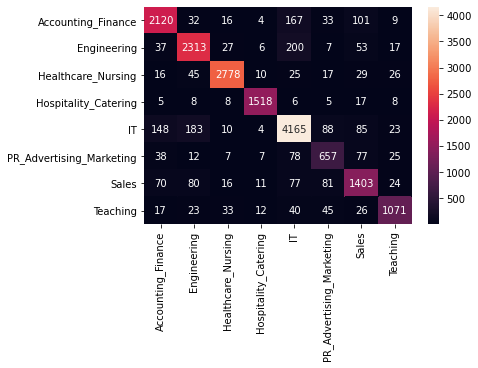

In [38]:
# Forming the unique list of job categories in alphabetical order to show in confusion matrix
job_ads_categories_unique_alphabetical = sorted(list(set(job_ads_categories)))

# Getting the predictions from the model
y_pred = model_score['predicted_categories']
conf_mat = confusion_matrix(y_test, y_pred)

# Plaotting the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=job_ads_categories_unique_alphabetical, yticklabels=job_ads_categories_unique_alphabetical);

Now, we will print the prediction statistics based on categories using `classification_report`. It will give us a comprehensive report grouped based on categories. It will have the following statistics.
- precision -> For all the predictions made on a category, what proportion is actually the predicted category
- recall -> For a category, proportion of correct predictions of that category out of the total.
- f1-score -> It is the harmonic mean of recall and precision.
- support -> The total number of data belonging to that category.

In [39]:
# Forming the classification report object so that it can be used for final comparison.
class_report_count_vector = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

      Accounting_Finance       0.86      0.85      0.86      2482
             Engineering       0.86      0.87      0.86      2660
      Healthcare_Nursing       0.96      0.94      0.95      2946
    Hospitality_Catering       0.97      0.96      0.96      1575
                      IT       0.88      0.89      0.88      4706
PR_Advertising_Marketing       0.70      0.73      0.72       901
                   Sales       0.78      0.80      0.79      1762
                Teaching       0.89      0.85      0.87      1267

                accuracy                           0.88     18299
               macro avg       0.86      0.86      0.86     18299
            weighted avg       0.88      0.88      0.88     18299



From the above stats of the model shown, we can draw the following conclusions.
- Accuracy of predictions is well above 90% for Healthcare_Nursing and Hospitality_Catering categories
- Accuracy of predictions is well below 80% for Sales and PR_Advertising_Marketing categories
- The remaining categories have its accuracy well above 85%.

So,<b> we can say that the accuracy of predictions is varying across the different categories</b>. After analysing the model prediction results from the remaining feature representations we can see if the same trend is followed.

For the word embeddings based feature representations, first we will visualise the features in a 2-Dimensional plot using t-SNE. A generic method is used for this since all the word embeddings will be using the same.

The method takes the following parameters:
   - labels -> These are the target variables.
   - features -> Document embeddings generated by the various models. This will be in the form of a numpy array.
   
The method works as follows:
   - Gets the sorted list of the unique labels
   - Setting a sample size - Here, we are considering 20% of the data as t-SNE is an expensive operation
   - Using numpy finding sample size number of random indices
   - Dimenisonality reduction using `TSNE`. We are plotting in 2 dimensions.
   - Defining the colors for the different categories so in visualistaion we can differentiate the categories
   - As there are huge number of points to be plotted setting the figure size to be 10*10
   - Looping through each of the unique categories.
   - Getting the projected feature representation of the looping category
   - Plotting the scatter plot of the looping category
   - Setting a title for the plot
   - Setting the legend and size
   - Added the command to show the plot when the plotting is done.

In [40]:
def plotTSNE(labels,features):
    categories = sorted(labels.unique()) # Getting the unique categories
    SAMPLE_SIZE = int(len(features) * 0.2) # Defining the size of sample from which the plot has to be created. 
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False) # Getting random indices.
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Dimenionality reduction takes place here.
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey', 'brown', 'black', 'yellow'] # Colors for distinguishing the categories.
    plt.figure(figsize=(10,10))
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i]) # Creating the scatter plot category wise.
    plt.title("Feature vector for each article, projected on 2 dimensions.", fontdict=dict(fontsize=15))
    plt.legend(prop={'size': 10})
    plt.show()

### Classification Model Based on FastText Unweighted Document Embeddings

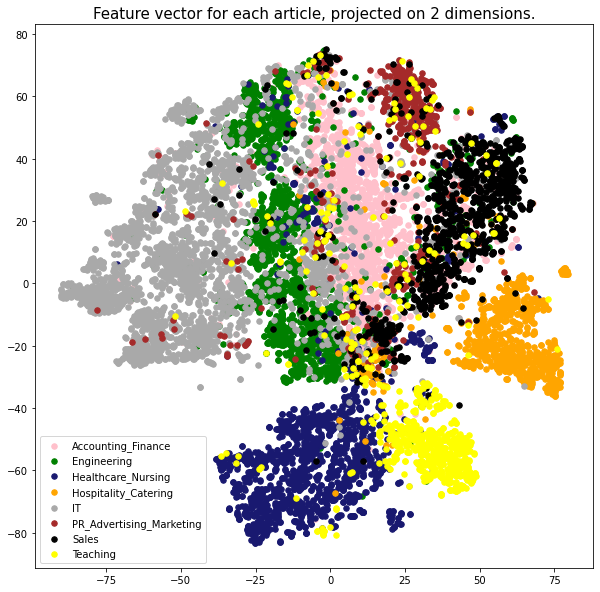

127.30539655685425

In [41]:
start = time.time()
# Plotting the t-SNE after converting the document embeddings after numpy array passing the categories as pandas series.
features = job_ads_dvs_FT.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

From the plot above we can see that there is a bit of noise in the data and hence it informs us that the model which we are going to create might be having a lesser accuracy. Even we can identify clusters from the plot.<b> If we recall the previous model we made based on count vector it was having an accuracy around 88%. And also, we found there the categories Healthcare_Nursing and Hospitality_Catering categories were having higher accuracy and from the plot we can see that those categories are having good separation represented by blue and orange dots respectively. We were having very low accuracy for PR_Advertising_Marketing categories and in the plot its dispersed throughout (red dots) </b>. Now we will move towards the model creation. Procedure will be the same as we have carried out for the count vector.

In [42]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_FT, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8646920596753921


176.45409107208252

As we have expected we got a value less than 90% for the accuracy of the model and we <b>can find that the value is 86.36% which is lower than the first one based on count vector representation</b>. Now ,we will analyse the statistics of the model prediction.

In [43]:
# Forming the classification report object so that it can be used for final comparison.
class_report_FT_unweighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.85      0.85      0.85      2482
             Engineering       0.85      0.86      0.85      2660
      Healthcare_Nursing       0.94      0.93      0.94      2946
    Hospitality_Catering       0.95      0.96      0.95      1575
                      IT       0.87      0.87      0.87      4706
PR_Advertising_Marketing       0.71      0.70      0.71       901
                   Sales       0.75      0.78      0.77      1762
                Teaching       0.90      0.83      0.86      1267

                accuracy                           0.86     18299
               macro avg       0.85      0.85      0.85     18299
            weighted avg       0.87      0.86      0.86     18299



The following conculsions can be drawn here:
   - Accuracy of predictions is well above 90% for Healthcare_Nursing and Hospitality_Catering categories but lower than the count vector model
   - Accuracy of predictions is well below 80% for Sales and PR_Advertising_Marketing categories but lower than the count vector model
   - The remaining categories have accuracy in the range 80%-90% but lower than the count vector model
   
#### Overall we get an impression that the accuracy has lowered by a small amount from count vectors and the trend of accuracies across the categories is same as in count vector model.

### Classification Model Based on FastText Weighted Document Embeddings

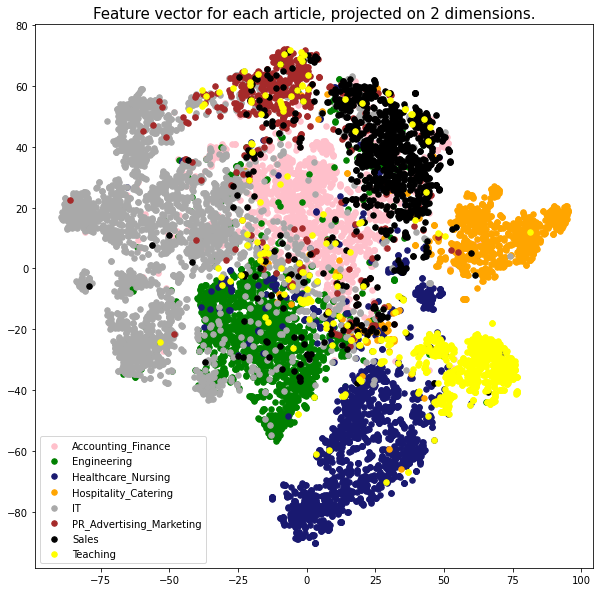

121.34153604507446

In [44]:
start = time.time()
# Plotting the t-SNE after converting the document embeddings after converting to numpy array.
features = job_ads_dvs_FT_weighted.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

The conclusion which we can draw from here is the exactly same conclusion we have arrived before. Dispersion of the points is slightly different but still overall its similar to before. So, we will directly proceed to the model creation.

In [45]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_FT_weighted, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8706486693261927


47.510233879089355

Here, <b>we can see that the accuracy is 87% and it is little higher than the unweighted couter part. This is expected since we have added the tf-idf weights to the vectors</b>. Now we will proceed with the statistics of the model prediction.

In [46]:
# Forming the classification report object so that it can be used for final comparison.
class_report_FT_weighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.86      0.85      0.86      2482
             Engineering       0.86      0.87      0.86      2660
      Healthcare_Nursing       0.95      0.94      0.94      2946
    Hospitality_Catering       0.95      0.96      0.96      1575
                      IT       0.87      0.88      0.87      4706
PR_Advertising_Marketing       0.70      0.73      0.71       901
                   Sales       0.76      0.79      0.77      1762
                Teaching       0.90      0.84      0.87      1267

                accuracy                           0.87     18299
               macro avg       0.86      0.86      0.86     18299
            weighted avg       0.87      0.87      0.87     18299



The following conculsions can be drawn here:
   - Accuracy of predictions is well above 90% for Healthcare_Nursing and Hospitality_Catering categories
   - Accuracy of predictions is well below 80% for Sales and PR_Advertising_Marketing categories
   - The remaining categories have accuracy in the range 80%-90%
   
#### Overall the trend of accuracies across the categories is same as in previous models.

### Classification Model Based on Word2Vec Unweighted Document Embeddings

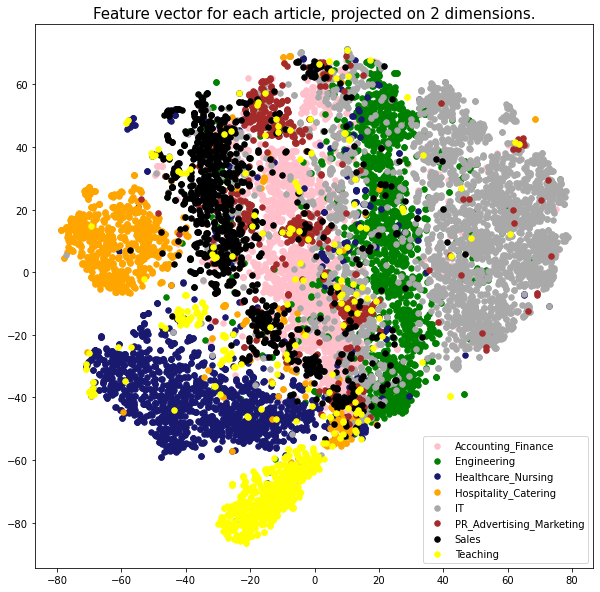

156.10340023040771

In [47]:
start = time.time()
# Converting the features to numpy array and plotting the t-SNE plot.
features = job_ads_dvs_w2v.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

The conclusion which we can draw from here is the exactly same conclusion we have arrived before. We can see some clusters but there is noise in the data. The clusters are having different shapes than earlier but overall it is similar. We will proceed with modelling part.

In [48]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_w2v, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8574785507404776


71.49827170372009

Again we can see that the accuracy is lesser than the count vector model. Analysing the model prediction statistics now.

In [49]:
# Forming the classification report object so that it can be used for final comparison.
class_report_w2v_unweighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.85      0.82      0.84      2482
             Engineering       0.85      0.85      0.85      2660
      Healthcare_Nursing       0.93      0.94      0.93      2946
    Hospitality_Catering       0.95      0.96      0.95      1575
                      IT       0.86      0.87      0.86      4706
PR_Advertising_Marketing       0.72      0.70      0.71       901
                   Sales       0.74      0.76      0.75      1762
                Teaching       0.87      0.84      0.85      1267

                accuracy                           0.86     18299
               macro avg       0.85      0.84      0.84     18299
            weighted avg       0.86      0.86      0.86     18299



The inferences we can draw from here is also the same as we have see before. <b>The accuracy trend across the categories is consistent with the others. And we can say that here the values are lower than that found vector model.</b>

### Classification Model Based on Word2Vec Weighted Document Embeddings

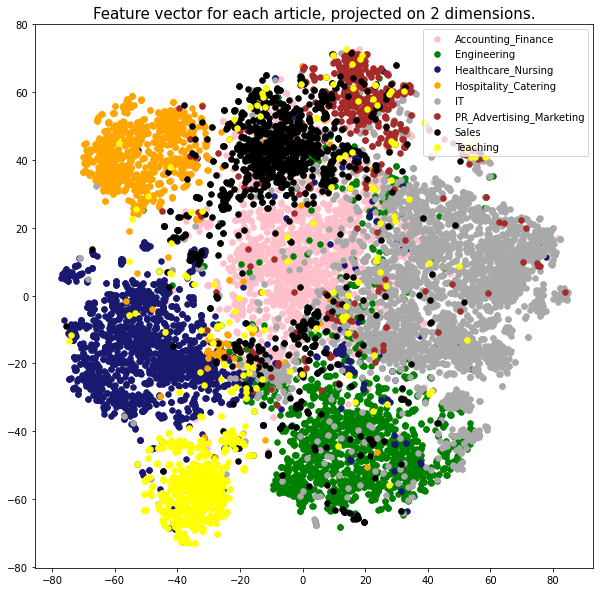

167.34922575950623

In [50]:
start = time.time()
# Converting the features to numpy array and plotting the t-SNE plot.
features = job_ads_dvs_w2v_weighted.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

We have nothing extra to say here as a peculiar behaviiour. The behaviour is exactly the same as we have seen before. So, proceeding with modelling.

In [51]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_w2v_weighted, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8637083993660856


20.43498396873474

<b>From the accuracy we can infer that it is lower than count vector but it is higher than the unweighted couter part</b>. Same behaviour we have observed with FastText also. We will analyse the classification report now.

In [52]:
# Forming the classification report object so that it can be used for final comparison.
class_report_w2v_weighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.85      0.83      0.84      2482
             Engineering       0.86      0.85      0.86      2660
      Healthcare_Nursing       0.94      0.94      0.94      2946
    Hospitality_Catering       0.96      0.96      0.96      1575
                      IT       0.86      0.88      0.87      4706
PR_Advertising_Marketing       0.72      0.73      0.72       901
                   Sales       0.75      0.77      0.76      1762
                Teaching       0.88      0.84      0.86      1267

                accuracy                           0.86     18299
               macro avg       0.85      0.85      0.85     18299
            weighted avg       0.86      0.86      0.86     18299



The inferences we can draw from here is also the same as we have see before. <b>The accuracy trend across the categories is consistent with the others. And we can say that here the values are lower than the count vector model.</b>

### Classification Model Based on Glove Unweighted Document Embeddings

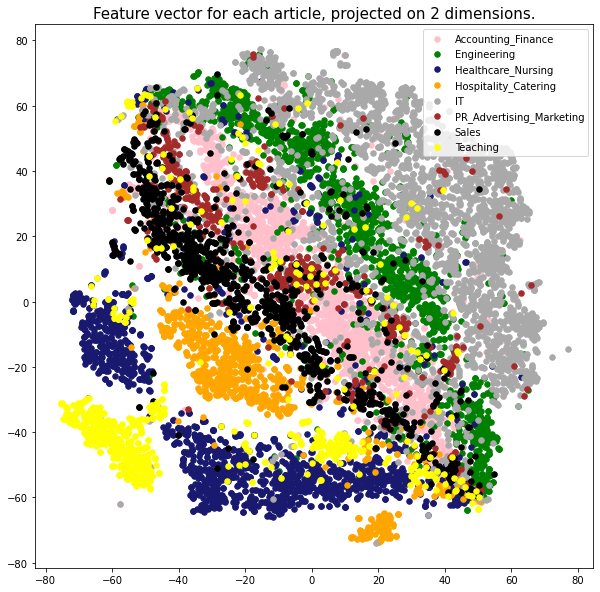

108.75153303146362

In [53]:
start = time.time()
# Converting the features to numpy array and plotting the t-SNE plot.
features = job_ads_dvs_glove.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

Again we can find the behaviour is same as before. Proceeding with modelling part.

In [54]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_glove, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8505382807803705


124.42682456970215

<b>Again we can see that the accuracy is lesser than the count vector model</b>. Analysing the model prediction statistics now.

In [55]:
# Forming the classification report object so that it can be used for final comparison.
class_report_glove_unweighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.83      0.83      0.83      2482
             Engineering       0.84      0.84      0.84      2660
      Healthcare_Nursing       0.92      0.93      0.93      2946
    Hospitality_Catering       0.95      0.95      0.95      1575
                      IT       0.85      0.87      0.86      4706
PR_Advertising_Marketing       0.73      0.68      0.71       901
                   Sales       0.74      0.75      0.74      1762
                Teaching       0.88      0.83      0.85      1267

                accuracy                           0.85     18299
               macro avg       0.84      0.83      0.84     18299
            weighted avg       0.85      0.85      0.85     18299



<b>The accuracy trend across the categories is consistent with the others</b>. There are no other inferences from here.

### Classification Model Based on Glove Weighted Document Embeddings

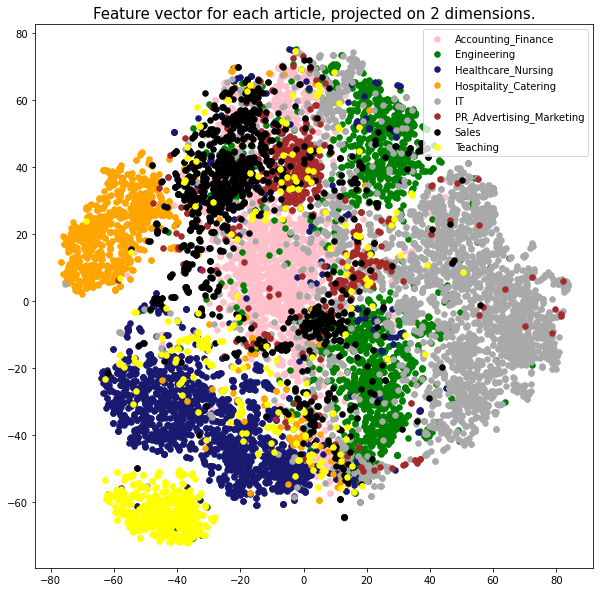

131.3816361427307

In [56]:
start = time.time()
# Converting the features to numpy array and plotting the t-SNE plot.
features = job_ads_dvs_glove_weighted.to_numpy()
plotTSNE(pd.Series(job_ads_categories),features)
time.time() - start

Again we can find the behaviour is same as before. Proceeding with modelling part.

In [57]:
start = time.time()

# Creation of the training and test data. We have used a test size of 0.33 as that is a normal standard value usually used.
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(job_ads_dvs_glove_weighted, job_ads_categories, list(range(0,len(job_ads_categories))),test_size=0.33, random_state=seed)

# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8504289851904475


51.506500244140625

<b>We can see that the prediction accuracy is lower than the count vector</b>. Analysing the model statistics

In [58]:
# Forming the classification report object so that it can be used for final comparison.
class_report_glove_weighted = classification_report(y_test, model_score['predicted_categories'], output_dict=True)
print(classification_report(y_test, model_score['predicted_categories']))

                          precision    recall  f1-score   support

      Accounting_Finance       0.84      0.82      0.83      2482
             Engineering       0.84      0.83      0.84      2660
      Healthcare_Nursing       0.93      0.93      0.93      2946
    Hospitality_Catering       0.95      0.95      0.95      1575
                      IT       0.85      0.87      0.86      4706
PR_Advertising_Marketing       0.71      0.70      0.70       901
                   Sales       0.73      0.75      0.74      1762
                Teaching       0.87      0.83      0.85      1267

                accuracy                           0.85     18299
               macro avg       0.84      0.83      0.84     18299
            weighted avg       0.85      0.85      0.85     18299



<b>Accuracy trend across categories follows the same as previous models</b>.

Now, we have done the modelling of all the 7 feature representations. Now, we will start the comparison of the different feature models. We have the statistics of each model available in different variables. We will arrange the variables in a good way to have a sensible comparison.

In [59]:
# Storing all the model stats as a list for further operations.
model_stats = [class_report_count_vector, class_report_FT_unweighted, class_report_FT_weighted, class_report_glove_unweighted, class_report_glove_weighted, class_report_w2v_unweighted, class_report_w2v_weighted]

# Creating the stats dictionary with the values of interest
stats_dict = {category:[] for category in job_ads_categories_unique_alphabetical}
stats_dict['accuracy'] = []

# Looping through each statistics of model and category
for stat in model_stats:
    for category in job_ads_categories_unique_alphabetical:
        stats_dict[category].append(stat[category]['recall'])
    stats_dict['accuracy'].append(stat['accuracy'])

# Printing the data frame that can be used for the comparison.
pd.DataFrame(stats_dict, index=['count vector', 'FastText Unweighted', 'FastText Weighted', 'Glove Unweighted', 'Glove Weighted', 'W2V Unweighted', 'W2V Weighted'])

,Accounting_Finance,Engineering,Healthcare_Nursing,Hospitality_Catering,IT,PR_Advertising_Marketing,Sales,Teaching,accuracy
count vector,0.854150,0.869549,0.942974,0.963810,0.885040,0.729190,0.796254,0.845304,0.875731
FastText Unweighted,0.850121,0.858647,0.933809,0.961270,0.872291,0.702553,0.779796,0.830308,0.864692
FastText Weighted,0.848912,0.866165,0.938900,0.964444,0.876328,0.731410,0.785471,0.843725,0.870649
Glove Unweighted,0.825544,0.835714,0.929735,0.950476,0.865491,0.684795,0.748014,0.827151,0.850538
Glove Weighted,0.817486,0.833835,0.925322,0.950476,0.871016,0.698113,0.745743,0.828729,0.850429
W2V Unweighted,0.824738,0.847368,0.939579,0.956190,0.867403,0.702553,0.761635,0.835833,0.857479
W2V Weighted,0.828364,0.851880,0.937203,0.960000,0.875478,0.732519,0.772418,0.843725,0.863708


The above data frame helps us to have a very good comparison of the categories and the accuracies of the different models. This concise view tells us  the following:
   - <b>All of the models have made better predictions for the categories Healthcare_Nursing and Hospitality_Catering and among them count vector has a good score.</b>
   - <b>The worst predictions are made for the categories PR_Advertising_Marketing and Sales</b>
   - <b>All the remaining categories were predicted with an accuracy above 80%.</b>
   
The overall picture here is telling us that count vector feature representation has better accuracy. But we cannot rely only on this. For a robust comparison, we need to do multi-fold comparison using `K-Fold`. As per the assignment we have to do a 5 fold validation. We will be starting it from the below code blocks.

In [28]:
# Specifying the number of folds
num_folds = 5
# initialising the Kfold split.
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True) # initialise a 5 fold validation
print(kf)

KFold(n_splits=5, random_state=0, shuffle=True)


As we have initialised the k-fold now we have to do cross validation on each of the 7 models.

The procedure is done as below:

- First, `model_score_obj` is created, This will be converted to a dataframe at the end.
- We will loop through each folds
- For each of the 7 models the model score is saved to `model_score_obj`
- Once the loop is done all the model score will be present in `model_score_obj`
- The dictionary is converted to a data frame and then can be seen as a dataframe

In [35]:
model_score_obj = {
        'count':[],
        'FT_unweighted':[],
        'FT_weighted':[],
        'w2v_unweighted':[],
        'w2v_weighted':[],
        'glove_unweighted':[],
        'glove_weighted':[]
    }

for train_index, test_index in kf.split(range(len(job_ads_categories))):
    
    start = time.time()
    
    y_train = [job_ads_categories[i] for i in train_index]
    y_test = [job_ads_categories[i] for i in test_index]
    
    X_train_count, X_test_count = count_features[train_index], count_features[test_index]
    model_score_obj['count'].append(model_accuracy(X_train_count, X_test_count, y_train, y_test)['accuracy'])
    
    X_train_FT_unweighted, X_test_FT_unweighted = job_ads_dvs_FT.iloc[train_index], job_ads_dvs_FT.iloc[test_index]
    model_score_obj['FT_unweighted'].append(model_accuracy(X_train_FT_unweighted, X_test_FT_unweighted, y_train, y_test)['accuracy'])
    
    X_train_FT_weighted, X_test_FT_weighted = job_ads_dvs_FT_weighted.iloc[train_index], job_ads_dvs_FT_weighted.iloc[test_index]
    model_score_obj['FT_weighted'].append(model_accuracy(X_train_FT_weighted, X_test_FT_weighted, y_train, y_test)['accuracy'])
    
    X_train_w2v_unweighted, X_test_w2v_unweighted = job_ads_dvs_w2v.iloc[train_index], job_ads_dvs_w2v.iloc[test_index]
    model_score_obj['w2v_unweighted'].append(model_accuracy(X_train_w2v_unweighted, X_test_w2v_unweighted, y_train, y_test)['accuracy'])
    
    X_train_w2v_weighted, X_test_w2v_weighted = job_ads_dvs_w2v_weighted.iloc[train_index], job_ads_dvs_w2v_weighted.iloc[test_index]
    model_score_obj['w2v_weighted'].append(model_accuracy(X_train_w2v_weighted, X_test_w2v_weighted, y_train, y_test)['accuracy'])
    
    X_train_glove_unweighted, X_test_glove_unweighted = job_ads_dvs_glove.iloc[train_index], job_ads_dvs_glove.iloc[test_index]
    model_score_obj['glove_unweighted'].append(model_accuracy(X_train_glove_unweighted, X_test_glove_unweighted, y_train, y_test)['accuracy'])
    
    X_train_glove_weighted, X_test_glove_weighted = job_ads_dvs_glove_weighted.iloc[train_index], job_ads_dvs_glove_weighted.iloc[test_index]
    model_score_obj['glove_weighted'].append(model_accuracy(X_train_glove_weighted, X_test_glove_weighted, y_train, y_test)['accuracy'])
    
    print(time.time() - start)
    
cross_validated_result = pd.DataFrame(model_score_obj)
cross_validated_result

49.995996952056885
51.01850867271423
47.737998723983765
46.0949981212616
44.59099793434143


,glove_unweighted,glove_weighted
0,0.850225,0.849143
1,0.852299,0.851668
2,0.846709,0.851668
3,0.847701,0.846709
4,0.857516,0.854901


We have the dataframe now. Next we will take the column means and arrage them based on the average means in the descending order. From this, we can conclude the best and worst model accuracies.

In [36]:
# Finding the column means and printing in descending order.
cross_validated_result.mean().sort_values(ascending=False)

glove_unweighted    0.850890
glove_weighted      0.850818
dtype: float64

### Language Model Comparison Conclusions

So, <b>from here we can find that the model based on count vector features is having the highest accuracy. But we can see that FT_weighted and count vectors are having almost very close accuracies</b>. Also the following conclusions can also be drawn from the data:

1. For all the word embeddings model, the tf-idf weighted models have higher accuracy than the unweighted counterpart
2. The word embeddings language models follows the order - FastText, Word2Vec and Glove which is having the lowest accuracy.
3. The overall range of the accuracies is 85% - 87.5%. We have considered a test size of 0.33 and that means 18299 was used as test data. 2.5% range is 458. This indicates the most accurate model predicted around 458 more observations with correct labels when compared with the model with the lowest accuracy.
4. One thing to be noted is that the order here will not be the same always. Based on the seed, test size maybe the model prediction accuracies might change.
5. Also there can be randomness associated with model building, train-test split etc. which will also impact the model accuracy.

In [63]:
time.time() - start_class

4767.814630508423

### Task 3.2 Does more information provide higher accuracy?

The task asks us whether a more accurate model can be constructed if we are considering the other details of the job advertisement like Title, Category etc. apart from description. We have to form models based on Title, Description(already done) and Title and Description together and see the accuracies to answer this research question.

First we will use the title of the each of the job advertisement and form a model and evaluate it to see the accuracy. We will see a sample of the titles first.

In [64]:
start_comp = time.time()

In [65]:
# Printing a sample of titles to see how to vectorize it
job_ads_titles[:10]

['Plant Engineer',
 'Residential Care Worker',
 'CHEF DE RANG FOR MICHELIN STARRED RESTAURANT',
 'Inpatient Ward Team Leader',
 'Information Services Support Analyst',
 'Physiotherapist  Cambridge',
 'Youth Justice Officer Job Luton',
 'Front End Web Developer  Slough  ****k****k',
 'NET / Web Developer  Clayton West, Huddersfield, West Yorkshire',
 'Senior Account Manager (Telecoms / IT)']

From the above we can understand that title is having multiple words in it. So, we will do the tokenizing based on the regular expression we have used for tokenizing descriptions in Task 1. And also we will convert the tokens to lower cases as we have followed for descriptions.

In [17]:
# Using the same pattern used for tokenizing description
pattern = r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?"
# Creating the tokenizer
tokenizer = RegexpTokenizer(pattern)

# Tokenizing the titles of the job advertisements.
tokenised_titles = [tokenizer.tokenize(title) for title in job_ads_titles]
# Converting the tokens to lower case
tokenised_titles = [[token.lower() for token in title] for title in tokenised_titles]
tokenised_titles[:10]

[['plant', 'engineer'],
 ['residential', 'care', 'worker'],
 ['chef', 'de', 'rang', 'for', 'michelin', 'starred', 'restaurant'],
 ['inpatient', 'ward', 'team', 'leader'],
 ['information', 'services', 'support', 'analyst'],
 ['physiotherapist', 'cambridge'],
 ['youth', 'justice', 'officer', 'job', 'luton'],
 ['front', 'end', 'web', 'developer', 'slough', 'k', 'k'],
 ['net',
  'web',
  'developer',
  'clayton',
  'west',
  'huddersfield',
  'west',
  'yorkshire'],
 ['senior', 'account', 'manager', 'telecoms', 'it']]

We have successfully tokenised the titles. Now we have to generate the feature representation of titles. Here, for consistency we will choose Glove Unweighted representation for titles. After comparing the accuracy of the model with the corresponding description counterpart we can see if more analysis is required. We have chosen Glove Unweighted here because it is having vector size of 200 and the word embeddings are readily available whereas for FastText we have to build it again and for Word2Vec we used 300 dimensions. 

For generating the title document vectors based on Glove Unweighted feature model following steps will be done:
- We will generate the title embeddings using `gen_docVecs` and the pre trained Glove word embeddings `preTrained_glove_wv`

In [18]:
start = time.time()
# Generating the document embeddings.
job_titles_dvs_glove = gen_docVecs(preTrained_glove_wv, tokenised_titles, 200)
# Ensuring there are no missing values.
print(job_titles_dvs_glove.isna().any().sum())
time.time() - start

0


30.52900218963623

We have generated the vector representation of titles. Now we will try to visualise this using t-SNE to see how much noise is there if we are using titles for classification task.

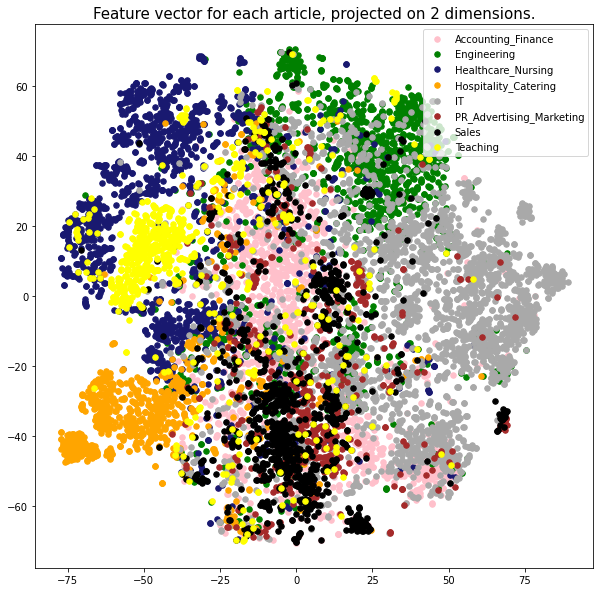

151.85967826843262

In [68]:
# Plotting the t-SNE plot.
start = time.time()
plotTSNE(pd.Series(job_ads_categories), job_titles_dvs_glove.to_numpy())
time.time() - start

We can see that the distribution of the data is more clumsier and much noise when compared with descriptions counterpart. This itself indicate that we might be getting a lower accuracy for the prediction model based on Title alone.

We will again use `LogisticRegression` here with the help of our generic function `model_accuracy`. 

In [19]:
start = time.time()
# Creating the training and testing data.
X_train, X_test, y_train, y_test = train_test_split(job_titles_dvs_glove, job_ads_categories, test_size=0.33, random_state=seed)
# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.7987868189518553


33.31699466705322

<b>We can see here the model accuracy is lower around 80% when compared with the descriptions counterpart which was having around 85%. So, we can rule out a classification task based on titles alone</b>. It will have lower accuracy. As the accuracy value is very low there is no need to do cross validation here since most probably cross validation will fluctuate between 78%-80% well below the glove unweighted descriptions counterpart.

We have already conducted the modelling based on description before with 7 different feature representations. Now, we have to combine both title and description and form a feature representation and we need to find out whether the accuracy can be improved. The following steps will be followed to calculate the accuracy of a model considering bot title and description.
- We already have the glove unweighted representation for both title and description as `job_titles_dvs_glove` and `job_ads_dvs_glove`
- We will combine both the data frames using `join`
- rsuffix (-title) will be added to `job_titles_dvs_w2v` to distinguish the column names between the dataframes
- The combined dataframe will be then used for modelling and getting the model accuracy

In [20]:
# Combining the dataframes with document embeddings of descriptions and titles for further processing.
combined_dvs_glove_description_title = job_ads_dvs_glove.join(job_titles_dvs_glove, rsuffix='-title')
combined_dvs_glove_description_title

,0,1,2,3,4,5,6,7,8,9,...,190-title,191-title,192-title,193-title,194-title,195-title,196-title,197-title,198-title,199-title
0,10.918798,14.297423,5.927130,0.659494,12.024599,1.394404,-31.231077,-3.011742,-13.575574,-9.850067,...,-0.014050,1.209510,-0.352345,-0.164050,0.334023,0.288395,0.561040,-0.304313,0.541860,0.772650
1,4.076064,0.517917,1.238005,-4.418650,8.593855,-7.339596,-18.639849,9.147700,-15.432754,25.014823,...,-0.185260,-0.034540,-0.187802,0.750793,-0.780833,-0.736731,-0.594163,1.126968,-0.708683,-0.441267
2,11.730541,8.209073,-3.489186,-6.906874,5.614323,-2.659150,-14.143227,-9.546805,-0.154613,-1.955393,...,-0.340133,1.174223,-3.237241,-0.675599,-0.216454,0.427878,0.840589,-1.354421,1.219525,2.163519
3,-1.189790,-0.336444,10.793366,-9.131248,-0.420840,-6.050924,-11.631077,4.602267,-2.700951,4.194036,...,0.773350,1.056589,0.303044,-0.009564,-0.837090,0.443367,-0.498771,-0.272149,-0.199237,-0.471080
4,6.624087,7.612899,5.708289,-9.197410,9.896589,0.032694,-11.769711,-0.985440,-2.040238,2.372797,...,0.326427,-0.355466,0.526784,1.315721,0.336815,-0.159937,-1.319160,-1.233740,1.424731,0.603910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,8.861749,38.235060,17.936110,-25.678077,25.540824,-12.540005,-47.017014,-0.913342,7.805696,19.815236,...,1.938200,0.310580,-1.232551,-0.146654,-0.775395,1.033227,0.257131,-0.922762,-0.167187,-0.048843
55445,18.225372,4.767893,3.384951,-7.339812,10.339972,-22.106273,-16.286044,10.856802,-7.121579,20.082343,...,0.047210,0.100840,-0.337990,0.271985,0.069040,0.346750,1.195760,-0.859930,0.255718,-0.323450
55446,-1.136254,22.775293,-11.453426,-21.928527,11.580332,-10.625074,-11.315679,3.656321,-1.211153,14.427938,...,-0.849500,-1.377389,0.107320,-0.537694,-0.269140,0.196229,-0.517512,0.867705,-0.758490,-0.747182
55447,10.504018,7.294560,8.504016,-2.665486,-6.945159,3.439162,-2.413436,6.080891,3.311685,-1.955998,...,-0.551209,-1.108260,-0.934925,-0.980484,0.591028,-0.311090,0.891470,0.566342,0.351700,0.028850


Now, we will plot the t-SNE graph to see how the feature vectors are distributed.

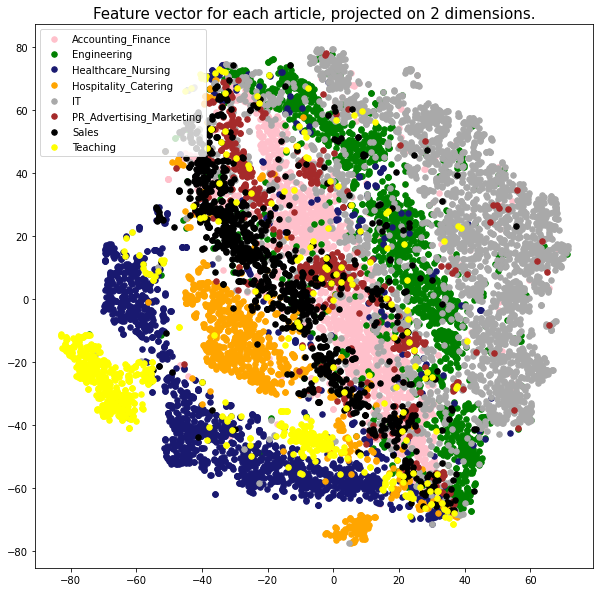

140.71190524101257

In [71]:
# Plotting the t-SNE plot.
start = time.time()
plotTSNE(pd.Series(job_ads_categories), combined_dvs_glove_description_title.to_numpy())
time.time() - start

Here, <b>we can see that there are clusters and it is more cleaner than the previous plot with only Title features. But, we cannot comment that here we have more accuracy. So, we have to do the modelling and find out the accuracy</b>. When we combined the dataframes we got a 400 sized vector. And as there are over 55000 data items to be iterated over and as we have combined two dataframes, for the LogisticRegression to converge we will be using scaled data, otherwise huge number of iterations are needed for the solution to converge which can in turn affect the accuracy of the model. The following steps will be followed here:
- We will split the combined document embeddings into training and testing data set using `train_test_split`
- We will create a pipeline estimator using `make_pipeline` from `sklearn.pipeline`. The method will take a list of estimators and process in the order. We will give the first estimator as `StandardScaler` from `sklearn.preprocessing` which will standardise the inputs for `LogisticRegression`. `StandardScaler` will standardize features by removing the mean and scaling to unit variance. Standardisation formula: (value - mean)/ Standard deviation. We will go with default arguments for `StandardScaler` which will consider the mean and standard deviation.
- After the pipe creation, training of the data is carried out in the pipe.
- At last, we will print the accuracy score from the pipe.

As we will be using the above steps more times we will creat a function performing all the above steps.

In [21]:
def model_score_pipeline(X_train, X_test, y_train, y_test):
#     Creation of the pipeline with StandardScaler() and LogisticRegression with maximum iterations set to 5000 since we are standardising the input data.
    pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000))
#     Fitting the model
    pipe.fit(X_train, y_train)
#     returning the accuracy score and category predcitions as a dictionary.
    return {'accuracy': pipe.score(X_test, y_test), 'predicted_categories': pipe.predict(X_test)}

start = time.time()

# Creating the training and testing data.
X_train, X_test, y_train, y_test = train_test_split(combined_dvs_glove_description_title, job_ads_categories, test_size=0.33, random_state=seed)

# Modelling the data and getting the accuracy score.
model_score = model_score_pipeline(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])

time.time() - start

0.8574785507404776


37.44902992248535

Here, <b>we can see that when we combined glove unweighted document embeddings and title document embeddings we got an accuracy of 85.7%. With glove unweighted we got an accuracy of 85.1%. This indicates we are having a small spike in the accuracy when title is also considered</b>. We have to ensure this. So we will do k-fold cross validation here again with the new  `model_score_pipeline` function.

We have already initialised 5 fold cross validation before. So , we will use the same here also. And here we will do the cross validation in a function as we will use it again. 

The function accepts the following arguments:
- combined_feature -> Feature representation with both Title and Description. 
- feature_name -> Name of the feature representation we are comparing with.
- feature_to_compare_with -> Feature document embeddings.

The function does the below:
- Will perform a 5 fold cross validation.
- Returns a model score object as a dataframe consisting of the accuracy scores of the 5 cross validations.

Also, in the below code block we will compare the cross validation result of title and description and description only feature representation based on glove unweighted model.

In [43]:
def cross_validate(combined_feature, feature_name, feature_to_compare_with):
#     Creation of the model score object holding the accuracies of the cross validations for different features
    model_score_obj = {
            'combined':[],
            feature_name:[]
        }

#     Loop for cross validation.
    for train_index, test_index in kf.split(range(len(job_ads_categories))):

        start = time.time()
#        Storing the training and testing target data
        y_train = [job_ads_categories[i] for i in train_index]
        y_test = [job_ads_categories[i] for i in test_index]

#         Modelling of the feature and updating accuracies to the model score object.
        X_train, X_test = combined_feature.iloc[train_index], combined_feature.iloc[test_index]
        model_score_obj['combined'].append(model_score_pipeline(X_train, X_test, y_train, y_test)['accuracy'])

        X_train, X_test = feature_to_compare_with.iloc[train_index], feature_to_compare_with.iloc[test_index]
        model_score_obj[feature_name].append(model_score_pipeline(X_train, X_test, y_train, y_test)['accuracy'])

        print(time.time() - start)
        
#   returning the dictionary as a dataframe.
    return pd.DataFrame(model_score_obj)
    
cross_validated_result = cross_validate(combined_dvs_glove_description_title, 'glove_unweighted', job_ads_dvs_glove)
cross_validated_result

101.3985984325409
89.28296399116516
87.43959760665894
76.00040936470032
76.4621787071228


,combined,glove_unweighted
0,0.856898,0.850225
1,0.863931,0.852299
2,0.856898,0.846709
3,0.859964,0.847701
4,0.869781,0.857516


If we compare the results of cross validations <b>we can find that combined title and description feature representation is having little higher accuracy than the corresponding description only counterpart</b>. We will see this by taking the means of the accuracy scores.

In [44]:
# Comparing with the mean value of the accuracies
cross_validated_result.mean().sort_values(ascending=False)

combined            0.861494
glove_unweighted    0.850890
dtype: float64

From the above it is clear that <b> when there is more information the accuracy of the model is increasing </b>. But its better if we double check the results. So, currently we have considered the glove language model. Now, we will go with word2vec unweighted model and compare the accuracies. First we will generate the document vectors for title using pre trained word2vec `preTrained_w2v_wv` which we have already done before.

In [75]:
start = time.time()
# Generating the document embeddings.
job_titles_dvs_w2v = gen_docVecs(preTrained_w2v_wv, tokenised_titles)
# Ensuring there are no missing values.
print(job_titles_dvs_w2v.isna().any().sum())
time.time() - start

0


81.55105400085449

We will just try to see the accuracy of the title based feature on word2vec language model.

In [76]:
start = time.time()
# Creating the training and testing data.
X_train, X_test, y_train, y_test = train_test_split(job_titles_dvs_w2v, job_ads_categories, test_size=0.33, random_state=seed)
# Generating the model accuracy
model_score  = model_accuracy(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])
time.time() - start

0.8109732772282638


13.001002311706543

Here, <b>we just had a look at the accuracy based on Title in word2vec model and see the value is around 81% which is lower the corresponding word2vec counterpart which is around 86%</b>. So, this again indicates that with only title the accuracy of the model is lower. Now, we will combine the title document embeddings and description document embeddings based on word2vec unweighted model.

In [77]:
# Combining the dataframes with document embeddings of descriptions and titles for further processing.
combined_dvs_w2v_description_title = job_ads_dvs_w2v.join(job_titles_dvs_w2v, rsuffix='-title')
combined_dvs_w2v_description_title

,0,1,2,3,4,5,6,7,8,9,...,290-title,291-title,292-title,293-title,294-title,295-title,296-title,297-title,298-title,299-title
0,-4.546768,5.067924,2.481800,2.889145,-5.867694,1.922361,1.819260,-5.643738,3.034363,2.692574,...,-0.097900,0.101807,-0.526367,0.412598,-0.168579,-0.492188,-0.553711,-0.268433,0.204102,-0.087891
1,-0.872101,0.557505,-0.474548,4.512268,-2.706406,-0.602787,3.192154,-3.002121,4.646362,-4.292419,...,-0.282204,-0.004364,-0.020752,0.131046,-0.336182,0.350098,-0.226562,0.152161,0.392456,-0.155792
2,-3.478378,1.442741,-1.097778,4.933929,-1.868793,1.896019,-0.223526,-5.567322,3.622606,2.308132,...,0.104916,-0.201843,-0.519653,1.320801,0.727661,-0.588390,0.275024,-0.713379,0.775879,0.527588
3,-3.872299,2.042828,0.468018,0.002045,-2.529800,0.126999,1.607147,-4.834270,5.598373,-3.731567,...,-0.242920,0.160156,-0.631836,0.108887,-0.202271,0.119995,-0.145203,0.163574,0.298828,0.549316
4,-2.315674,0.330042,0.247406,1.883667,-1.592896,-1.544556,2.662231,-4.661743,3.335389,-0.686310,...,-0.073242,-0.066895,0.362305,-0.243111,0.595215,-0.008240,0.302185,0.018768,0.299438,-0.284668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,-6.506058,3.951706,-3.012321,-0.288738,-4.345215,-0.263962,7.712452,-4.252290,12.016479,-5.474796,...,0.009766,-0.076996,-0.160645,0.194092,0.020386,-0.442871,0.953125,-0.245605,0.027832,0.340820
55445,-4.608643,3.788315,2.073846,6.964081,-1.779922,0.394180,4.353258,-9.971779,2.855761,-0.319389,...,0.243896,-0.069824,-0.460938,-0.066925,0.201172,0.232422,-0.034668,-0.171875,0.245361,-0.151855
55446,-1.948257,3.651352,-0.931793,3.458700,-2.773972,0.513422,6.540438,-9.362244,9.024445,7.087097,...,-0.515503,0.307281,-0.348389,0.331055,0.060547,0.443604,-0.298584,-0.118805,0.261360,-0.208496
55447,-1.164276,1.451782,-1.223419,0.404083,-0.152405,1.391483,2.597244,-2.492096,4.274567,1.205307,...,0.058350,0.011963,-0.162628,0.355469,0.153809,-0.160522,0.370117,-1.029297,-0.092285,-0.129456


Here we are not going to plot the t-SNE as it is very time consuming. We will directly proceed with the modelling part using the function `model_score_pipeline` because of the same reasons we have mentioned before.

In [78]:
start = time.time()

# Creating the training and testing data.
X_train, X_test, y_train, y_test = train_test_split(combined_dvs_w2v_description_title, job_ads_categories, test_size=0.33, random_state=seed)

# Modelling the data and getting the accuracy score.
model_score = model_score_pipeline(X_train, X_test, y_train, y_test)
print(model_score['accuracy'])

time.time() - start

0.8590633367943603


43.685004234313965

Here also we can see that the accuracy is just around 86%. So, here we are having almost the same accuracy with the extra information title added. For having a robust confirmation we will do a 5 fold cross validation using the function `cross_validate` and compare the accuracies.

In [79]:
# Performing the cross validation.
cross_validated_result = cross_validate(combined_dvs_w2v_description_title, 'w2v_unweighted', job_ads_dvs_w2v)
cross_validated_result

90.7611951828003
89.73810243606567
87.6510317325592
91.93397498130798
88.96100544929504


,combined,w2v_unweighted
0,0.862849,0.859964
1,0.866907,0.859693
2,0.862940,0.861046
3,0.859784,0.856087
4,0.870232,0.865182


Here, we can see that for each fold, <b>the combined features representation is having a little higher accuracy than the description only counterpart</b>. We will check the mean of accuracies now.

In [80]:
# Comparing with the mean value of the accuracies
cross_validated_result.mean().sort_values(ascending=False)

combined          0.864542
w2v_unweighted    0.860394
dtype: float64

From the above it is clear that <b> when there is more information the accuracy of the model is increasing even though its a very slight increase in percentage </b>. If we closely analyse we can say the following:
- There is a 0.004% approximate accuracy difference between the two representations.
- The size of the test data  = 0.33 * 55449 = 18299
- So, 0.004% means approximately 73 observations more were predicted correctly by the combined feature representation.

#### So, overall we can say that when we add more information it can have a positive effect on the accuracy of the model which is evident with the glove and word2vec representations comparison. 

In [81]:
time.time() - start_comp

1395.0257680416107

In [82]:
time.time() - start_doc

9807.758611679077

## Summary

In the assessment task we have created 7 different feature representations for the job advertisement descriptions and did the modelling for all the features. We did compare and analysed the different feature representations and came to the conclusion that the count vector and FastText unweighted representations were having the highest accuracy with count vector having little higher value for the accuracy. Also, we observed that across the different categories the accuracy of predictions varied and the trend was common with all the 7 representations. Here, we can depend on our results since we have done 5 fold cross validation and hence the results obtained can be considered robust. We could also observe that the visualisation done by using t-SNE was very helpful in making a quick overview of the data. The follwoing can be considered as the key takeaways from the assignment:
- Naming of the variables should be such that it will be helpful for othere who go thorugh our code.
- Whenever there is a chance that certain steps need to executed multiple times, make it a generic function
- Always, follow the same structure throughout for the same thing done with different approaches
- Ensure the robustness of the models created by cross validation rather depending on a single run since accuracies can change based on the parameters chosen for the model.
- Always try to generate concise and meaningful data representations which will help to compare the different approaches effectively and to get valuable insights. 